In [1]:
# 导入工具包
# opencv读取图片的格式为b g r
# matplotlib图片的格式为 r g b
import numpy as np
import cv2
# from imutils import contours
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 信用卡的位置
predict_card = "image/credit_card_01.png"
# 模板的位置
template = "image/ocr_a_reference.png"

In [3]:
# 指定信用卡类型
FIRST_NUMBER = {
    "3": "American Express",
    "4": "Visa",
    "5": "MasterCard",
    "6": "Discover Card"
}

In [4]:
# 定义一些功能函数

# 对框进行排序
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0

    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts] #用一个最小的矩形，把找到的形状包起来x,y,h,w
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))

    return cnts, boundingBoxes

# 调整图片尺寸大小
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

# 定义cv2展示函数
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

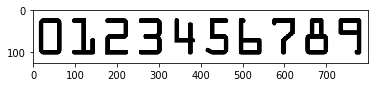

In [5]:
# 读取模板图像
img = cv2.imread(template)
cv_show("img",img)
plt.imshow(img)

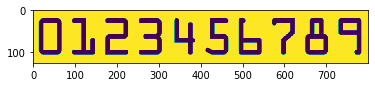

In [6]:
# 转灰度图
ref = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv_show("ref",ref)
plt.imshow(ref)

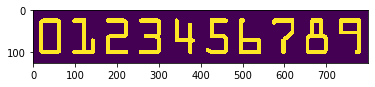

In [7]:
ref = cv2.threshold(ref,10,255,cv2.THRESH_BINARY_INV)[1]
cv_show("ref",ref)
plt.imshow(ref)

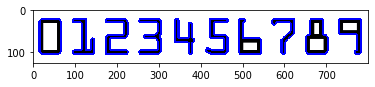

In [8]:
#cv2.findContours()函数接受的参数为二值图，即黑白的（不是灰度图）,cv2.RETR_EXTERNAL只检测外轮廓，cv2.CHAIN_APPROX_SIMPLE只保留终点坐标
#返回的list中每个元素都是图像中的一个轮廓
# 在二值化后的图像中计算轮廓
_,refCnts,hierarchy = cv2.findContours(ref.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
# 在原图上画出轮廓
cv2.drawContours(img,refCnts,-1,(0,0,255),3)
cv_show("img",img)
plt.imshow(img)

In [9]:
print(np.array(refCnts).shape)
# 排序，从左到右，从上到下
refCnts = sort_contours(refCnts,method="left-to-right")[0] 
digits = {}

# 遍历每一个轮廓
for (i, c) in enumerate(refCnts):
    # 计算外接矩形并且resize成合适大小
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))

    # 每一个数字对应每一个模板
    digits[i] = roi

(10,)


C:\py\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


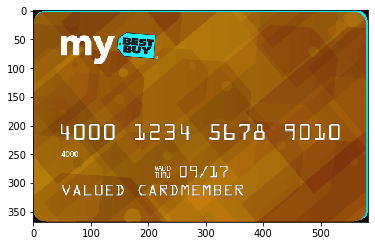

In [11]:
image = cv2.imread(predict_card)
cv_show("image",image)
plt.imshow(image)

In [24]:
# 先对图像进行resize操作
image = resize(image,width=300)
# 灰度化处理
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
cv_show("gray",gray)

# 对图像礼帽操作

礼帽 = 原始输入-开运算结果

开运算:先腐蚀，再膨胀

突出更明亮的区域

In [25]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

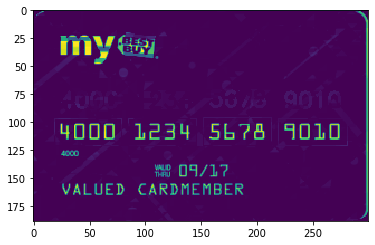

In [26]:
tophat = cv2.morphologyEx(gray,cv2.MORPH_TOPHAT,rectKernel)
cv_show("tophat",tophat)
plt.imshow(tophat)

(189, 300)


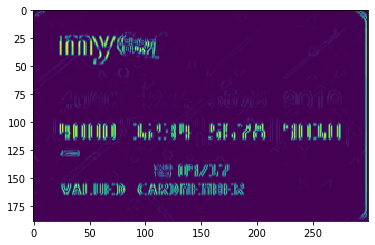

In [27]:
#边缘检测
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")
print (np.array(gradX).shape)
cv_show("gradX",gradX)
plt.imshow(gradX)

# 对图像闭操作

闭操作:先膨胀，再腐蚀

可以将数字连在一起

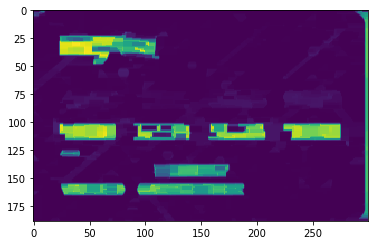

In [28]:
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel) 
cv_show("gradX",gradX)
plt.imshow(gradX)

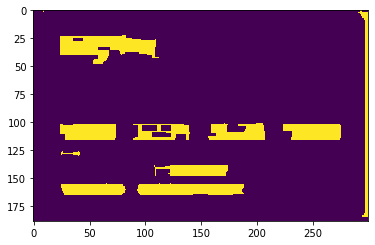

In [29]:
#THRESH_OTSU会自动寻找合适的阈值，适合双峰，需把阈值参数设置为0
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
cv_show("thresh",thresh)
plt.imshow(thresh)

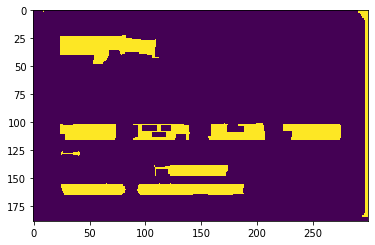

In [30]:
# 再进行一次闭操作
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel) #再来一个闭操作
cv_show("thresh",thresh)
plt.imshow(thresh)

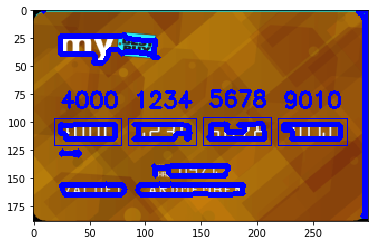

In [31]:
_,threshCnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = threshCnts
cur_img = image.copy()
cv2.drawContours(cur_img,cnts,-1,(0,0,255),3) 
cv_show("img",cur_img)
plt.imshow(cur_img)

In [20]:
locs = []

# 遍历轮廓
for (i, c) in enumerate(cnts):
    # 计算矩形
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # 选择合适的区域，根据实际任务来，这里的基本都是四个数字一组
    if ar > 2.5 and ar < 4.0:
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            #符合的留下来
            locs.append((x, y, w, h))

# 将符合的轮廓从左到右排序
locs = sorted(locs, key=lambda x:x[0])
output = []

# 模板匹配

In [21]:
# 遍历每一个轮廓中的数字
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # initialize the list of group digits
    groupOutput = []

    # 根据坐标提取每一个组
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    cv_show("group",group)

    # 预处理
    group = cv2.threshold(group, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    cv_show("group",group)

    # 计算每一组的轮廓
    _,digitCnts,hierarchy = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = sort_contours(digitCnts,method="left-to-right")[0]

    # 计算每一组中的每一个数值
    for c in digitCnts:
        # 找到当前数值的轮廓，resize成合适的的大小
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
        cv_show("roi",roi)

        
        # 计算匹配得分
        scores = []
        # 在模板中计算每一个得分
        for (digit, digitROI) in digits.items():
            # 模板匹配
            result = cv2.matchTemplate(roi, digitROI,cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)

        # 得到最合适的数字
        groupOutput.append(str(np.argmax(scores)))

    # 画出来
    cv2.rectangle(image, (gX - 5, gY - 5),(gX + gW + 5, gY + gH + 5), (0, 0, 255), 1)
    cv2.putText(image, "".join(groupOutput), (gX, gY - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

    # 得到结果
    output.extend(groupOutput)

Credit Card Type: Visa
Credit Card #: 4000123456789010


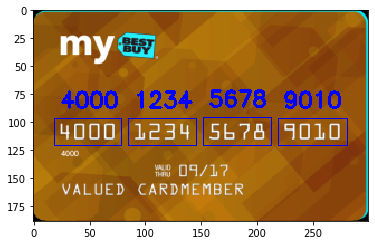

In [22]:
# 打印结果
print("Credit Card Type: {}".format(FIRST_NUMBER[output[0]]))
print("Credit Card #: {}".format("".join(output)))
cv_show("Image",image)
plt.imshow(image)